# BEE 4750 Lab 2: Uncertainty, Monte Carlo, and Simple Climate Models

**Name**:

**ID**:

> **Due Date**
>
> Friday, 9/22/23, 9:00pm

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

In [2]:
using Random # random number generation
using CSV # working with comma-delimited files
using DataFrames # working with tabular data
using Distributions # probability distributions and interface
using Statistics # basic statistical functions, including mean
using Plots # plotting

## Introduction

In this lab, you will use Monte Carlo analysis to look at uncertainty in
the projections generated by a *simple climate model*. This model treats
the Earth system as a single “box” (a 0-dimensional sphere covered by
water) which is subject to an energy balance, hence why it is called an
*energy balance model*. More complex climate models exist which use
multiple boxes, such as two-box models which separates the tropics from
the poles or the ocean from the atmosphere, or more complex models which
include additional reservoirs and heat fluxes between them.

> Credit to Nathan Urban (Brookhaven National Laboratory) for inspiring
> this lab, which is adapted from a notebook he provided.

### Climate Change and Global Mean Temperatures

The extent to which the climate has and might change is often expressed
through changes in global mean temperature. Let’s look at how global
mean temperatures have changed from 1850–2022 relative to a baseline
value of the mean temperature from 1850–1900, which is the normalization
used by the Intergovernmental Panel on Climate Change (IPCC).

> **Preindustrial Baselines**
>
> Global temperature values (and many other markers of climate change,
> such as global mean sea levels) are expressed as *anomalies* from a
> certain reference value, as we are primarily interested in changes
> from those values. For global temperatures, these are often chosen to
> represent a supposedly pre-industrial climate (or as close as the data
> will allow us to get to that baseline). The choice of that baseline is
> not standardized, and impacts the quantified level of warming, but
> it’s easy to change the baseline if you’re uncertain what baseline was
> used for a given dataset.


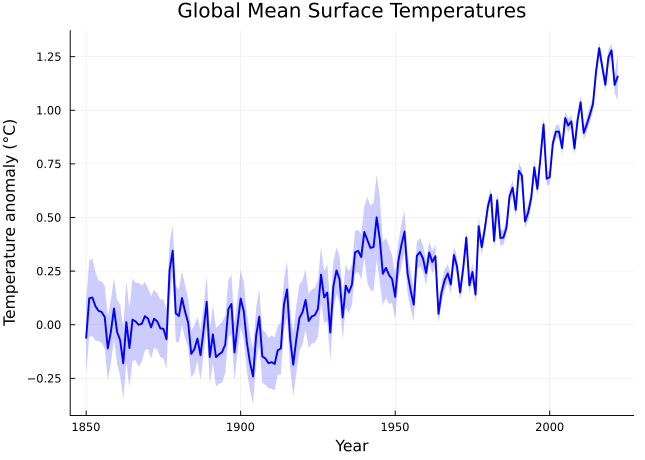

In [3]:
# Data from https://crudata.uea.ac.uk/cru/data/temperature/
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
temp_data = CSV.read("data/HadCRUT.5.0.1.0.analysis.summary_series.global.annual.csv", DataFrame, delim=",")

# The syntax df[!, "colname"] selects the entire column named "colname" but does not make and return a copy
# To get a copy (for example, if you want to modify that vector but not the original dataframe), use df[:, "column"]
# If we wanted to only select a range of rows, use df[row_index, "colname"], where row_index could be a single value, a numerical or Boolean array
time_obs = temp_data[!, "Time"] # years
temp_obs = temp_data[!, "Anomaly (deg C)"] # GMT estimate
temp_obs_lo = temp_data[!, "Lower confidence limit (2.5%)"] # 2.5% confidence level
temp_obs_hi = temp_data[!, "Upper confidence limit (97.5%)"] # 97.5% confidence level

temp_baseline = mean(temp_obs[1:51]) # get 1850-1900 baseline for renormalization
temp_obs = temp_obs .- temp_baseline
temp_obs_lo = temp_obs_lo .- temp_baseline
temp_obs_hi = temp_obs_hi .- temp_baseline

# The ribbon=(...) argument plots a ribbon around the main y-axis value and can be passed as a single array (for a symmetric error bound or a tuple of arrays (for lower/upper bounds, as below))
plot(time_obs, temp_obs, ribbon=(temp_obs - temp_obs_lo, temp_obs_hi - temp_obs), color="blue", linewidth=2, fillalpha=0.2, legend=false, title="Global Mean Surface Temperatures", xlabel="Year", ylabel="Temperature anomaly (°C)")

What do you notice in
<a href="#fig-gmt" class="quarto-xref">Figure 1</a>?

### Radiative Forcing

Climatic changes result from changes to the heat or energy balance of
the Earth (the balance between incoming solar radiation and outgoing
radiation which is emitted back to space). These changes are due to
alterations to the chemical composition of the atmosphere, which
include:

-   greenhouse gas emissions (which trap radiation, warming the planet);
-   aerosol emissions from air pollution or volcanic eruptions (which
    block incoming radiation, cooling the planet);
-   changes to the solar cycle (which can increase or decrease the
    incoming solar radiation).

The impact of these on the energy balance of the planet are referred to
as *radiative forcing*. Radiative forcing is measured in terms of
watts/square meter (W/m<sup>2</sup>). A positive radiative forcing means
a warming effect (net heat increase) and a negative radiative forcing
means a cooling effect (net heat loss).

Let’s start by reading in a file which contains historical and projected
radiative forcings. The historical forcings go from 1750–2014. The
future projections correspond to one of the Radiative Concentration
Pathways (RCPs), which are the official scenarios used to assess future
climate change and its potential impacts. In this case, we will be
looking at RCP 8.5, which is a future climate scenario which assumes an
extremely large amount of future fossil fuel use and is often treated as
an upper bound on future climate change. The switch from historical to
projected forcings in 2014 means that the last years of real-world
forcings are not reflected.

We’ll separate out several different contributors to the total radiative
forcings (CO<sub>2</sub>, aerosols, and other).


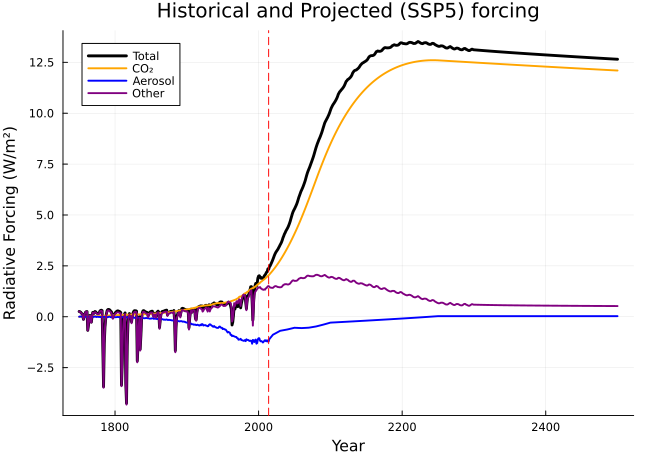

In [4]:
# Dataset from https://zenodo.org/record/3973015
# The CSV is read into a DataFrame object, and we specify that it is comma delimited
forcings_all = CSV.read("data/ERF_ssp585_1750-2500.csv", DataFrame, delim=",")

# Separate out the individual components
forcing_co2 = forcings_all[!,"co2"]
# Get total aerosol forcings
forcing_aerosol_rad = forcings_all[!,"aerosol-radiation_interactions"]
forcing_aerosol_cloud = forcings_all[!,"aerosol-cloud_interactions"]
forcing_aerosol = forcing_aerosol_rad + forcing_aerosol_cloud
forcing_total = forcings_all[!,"total"]
forcing_non_aerosol = forcing_total - forcing_aerosol
forcing_other = forcing_total - (forcing_co2 + forcing_aerosol)

t = time_forcing = Int64.(forcings_all[!,"year"]) # Ensure that years are interpreted as integers

plot(title="Historical and Projected (SSP5) forcing", xlabel="Year", ylabel="Radiative Forcing (W/m²)")
plot!(time_forcing, forcing_total, label="Total", color=:black, linewidth=3)
plot!(time_forcing, forcing_co2, label="CO₂", color=:orange, linewidth=2)
plot!(time_forcing, forcing_aerosol, label="Aerosol", color=:blue, linewidth=2)
plot!(time_forcing, forcing_other, label="Other", color=:purple, linewidth=2)
vline!([2014], label="", color=:red, linestyle=:dash)

Notice that the historical forcings in
<a href="#fig-radiative" class="quarto-xref">Figure 2</a> are a lot less
“smooth”: this is common when comparing historical data to model
projections. We can also see that although aerosol forcings become
negative (due to an increase in aerosols), the radiative forcing impact
of CO<sub>2</sub> emissions is much larger.

### The Simplest Climate Model: Energy Balance

As mentioned above, we will be looking at the simplest possible climate
model, the energy balance model (EBM). It treats the Earth as a
0-dimensional sphere covered in water, which is defensible as most of
the heat capacity of the climate system is in the oceans. The Earth
warms due to an imbalance between the heat flux (radiative forcing)
entering the climate system vs. heat flux leaving (through blackbody
radiation), per square meter of the Earth’s surface.

A linear differential equation for this imbalance is
$$\frac{dH}{dt} = F - \lambda T,$$ where $H(t)$ is heat, $F(t)$ is
radiative forcing (RF), $T$ is surface (or water) temperature anomaly,
and $\lambda$ is a proportionality coefficient representing the
efficiency with which heat leaves the Earth. Heat is proportional to
temperature change, so we can rewrite this in terms of temperature $T$:
$$C \frac{dT}{dt} = F - \lambda T,$$ where $C$ is the heat capacity of
the water layer; this can also be written as
$$cD\frac{dT}{dt} = F - \lambda T$$ where $c\approx 4.184\times 10^6$
J/K/m$^2$ is the specific heat of water (per area rather than volume)
and $D$ is the depth of the water layer, which we take as equivalent to
the upper mixed layer of the ocean (\$\$50-100 m deep), which mixes
homogeneously with the atmosphere and whose temperature is assumed to be
equal to the surface temperature.

### Equilibrium Climate Sensitivity and the Feedback Factor

Suppose that we were to apply a constant radiative forcing $F$ to the
planet under this model. Then, under a steady-state or equilibrium
condition $dT/dt = 0$, the final equilibrium temperature would be
$$T = \frac{F}{\lambda}.$$ In other words, the proportionality
coefficient $\lambda$ controls the level of warming under equilibrium.
For the specific case where $F$ is due to a doubling of atmospheric
CO<sub>2</sub> (\$F\_{2\_2} ^2), the final equilibrium temperature is
called *equilibrium climate sensitivity (ECS)* $S$,
$$S = F_{2\times \text{CO}_2}/\lambda.$$

The $\lambda$ parameter is known as the *feedback factor* because if
feedbacks occur in the climate system, such as changes in how much
sunlight or heat is absorbed or reflected by the surface or clouds or
evaporated water, they modify the rate at which heat leaves the Earth,
which is the role of the $-\lambda T$ term in the EBM.

### Solving the Energy Balance Model

Solving the EBM is straightforward by discretizing the equation using
the Euler method: $$
\begin{align*}
&C dT/dt = F - \lambda T \\
& \Rightarrow C (T_{i+1}-T_i)/\Delta t = F_i - \lambda T_i \\
& \Rightarrow T_{i+1} = T_i + (F_i - \lambda T_i)/C \times \Delta t
\end{align*}
$$

### A Sidebar: Aerosol Scaling

The forcing effect of aerosols is a major uncertainty for climate
models. Sulfur dioxide gas (SO<sub>2</sub>), a pollutant, reacts with
water to form aerosolized droplets of sulfuric acid (a major component
of acid rain) which reflects sunlight and causes cooling (the *aerosol
direct effect*). However, these aerosols also serve as cloud
condensation nuclei, altering cloud formation, brightness, and lifetime,
which can also have a cooling or warming effect (the *aerosol indirect
effect*). We are unsure about the strength of these effects,
particularly the aerosol indirect effect. To reflect this uncertainty,
we separate the radiative forcing into aerosol and non-aerosol
components, and put an uncertain multiplicative scale factor $\alpha$ in
front of the aerosol forcing:
$$F = F_\text{non-aerosol} + \alpha F_\text{aerosol}.$$

### Implementing the EBM in Julia

We’re finally ready to implement the EBM in Julia. We will treat only
the ECS $S$ as uncertain for the purposes of this lab, and use typical
values of $d=100 \text{m}$ for the mixed-layer depth and a best estimate
of aerosol scaling ($\alpha=1.2$).

In [5]:
# The arguments after the semi-colon are optional keyword arguments: these can be changed by explicitly setting them (as in EBM(S; forcing_non_aerosol=some_other_forcing)), but if left blank (as in EBM(S)) will just use the default values set in the function definition.
function EBM(S; forcing_non_aerosol=forcing_non_aerosol, forcing_aerosol=forcing_aerosol)
    d = 100 # ocean mixing depth (m)
    α = 1.2 # aerosol scaling factor

    F2xCO₂ = 4.0 # RF (W/m^2) from doubling CO2
    λ = F2xCO₂/S # Equilibrium condition for constant RF

    c = 4.184e6 # heat capacity/area (J/K/m²)
    C = c * d # heat capacity of mixed layer ()
    F = forcing_non_aerosol + α * forcing_aerosol # radiative forcing

    Δt = 31558152.0 # annual timestep (s); the .0 at the end causes Julia to interpret this as a float instead of an integer

    T = zero(F) # initialize array of zeros with length equal to length of F
    # loop over the time steps and update temperatures using discretized equation
    for i in 2:length(F)
        T[i] = T[i-1] + (F[i-1] - λ * T[i-1])/C * Δt
    end

    return T
end

EBM (generic function with 1 method)

For example, running the model with $S=3.1^\circ\text{C}$ (which is the
central estimate from Sherwood et. al. (2020)) produces the following
time results.


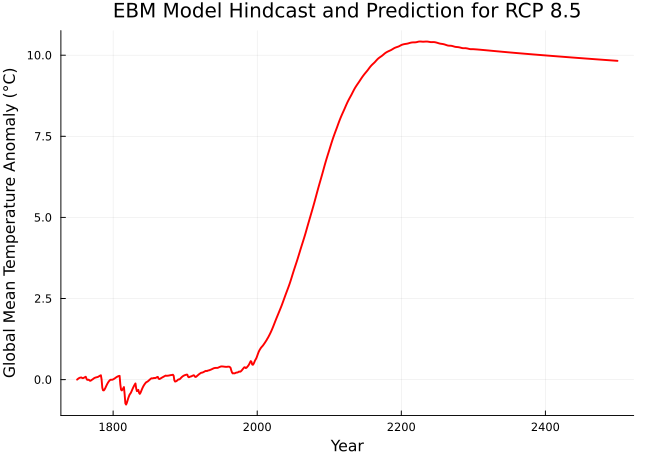

In [6]:
T = EBM(3.1)

plot(t, T, linewidth=2, title="EBM Model Hindcast and Prediction for RCP 8.5", label=false, xaxis="Year", yaxis="Global Mean Temperature Anomaly (°C)", color=:red)

How does this compare to observations?


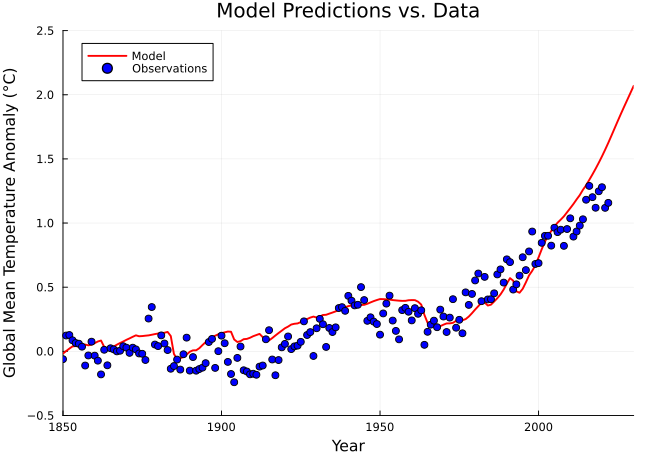

In [7]:
plot(t, T, label="Model", color="red", linewidth=2, xlim=(1850,2030), ylim=(-0.5,2.5), title="Model Predictions vs. Data", xlabel="Year", ylabel="Global Mean Temperature Anomaly (°C)")
scatter!(time_obs, temp_obs, label="Observations", color="blue")

We won’t quantify how well this fits, but what do you think based on a
visual inspection?

That model run was just for a single value of the ECS, but this is
actually a highly uncertain parameter. The “true” value of the ECS is
hard to identify because of transient dynamics in the Earth system which
confound isolating the equilibrium effect. For example, higher rates of
heat uptake by the ocean would reduce surface temperatures even if ECS
was higher.

## Exercises (10 points)

The goal of these exercises is to use Monte Carlo sampling to see how
uncertainty in the ECS propagates through the EBM, resulting in
uncertain temperature projections.

To approximate the ECS distribution from Sherwood et al (2020), we can
use a log-normal distribution, which is a distribution obtained by
exponentiating normally-distributed samples (which ensures positive
values). A log-normal distribution is parametrized by the log-mean $\mu$
and scale parameter (which is related to but is *not* the standard
deviation) $\sigma$, which controls the spread of the distribution. For
the ECS, we will use $$S \sim LogNormal(1.19, 0.22).$$

**Remember to**:

-   Evaluate all of your code cells, in order (using a `Run All`
    command). This will make sure all output is visible and that the
    code cells were evaluated in the correct order.
-   Tag each of the problems when you submit to Gradescope; a 10%
    penalty will be deducted if this is not done.

### Exercise 1: Making a Histogram From Samples (3 points)

Create a histogram of the ECS distribution by drawing samples from
$LogNormal(1.19, 0.22)$. Make sure to set a random seed using
`Random.seed!(seed_val)`, where `seed_val` is some integer (it doesn’t
matter which one you pick), as this will ensure that you get the same
samples regardless of when you evaluate your notebook code.

In general, the syntax to draw samples from a log-normal distribution
using `Distributions.jl` is:

``` julia
dist = LogNormal(μ, σ) # create the distribution object; name it whatever
samples = rand(dist, n) # draw n samples from dist
```

How did you decide how many samples to draw and plot? Plot the expected
value (using the `mean()` function from `Statistics.jl`) over the
histogram using `vline!()` (see the radiative forcing plot above for an
example).

### Exercise 2: Monte Carlo (4 points)

Use the `EBM()` function to propagate ECS samples and obtain a
distribution of temperature anomalies in 2100. To find the index which
corresponds to 2100, look up which element of the time vector is 2100
with `indexin(2100, t)` to find the first element which matches 2100
(you can use `findall()` if you think there would be multiple matches
and want to find them all, which is not the case here).

What is the expected value of the global mean temperature anomaly in
2100? How did you decide how many samples to use?

### Exercise 3: Making a Plot (3 points)

Compare the expected value of the global mean temperature anomaly in
2100 from Exercise 2 with the global mean temperature anomaly obtained
by propagating the expected value of ECS. Plot these values over a
histogram of your global mean temperature anomaly samples from Exercise
2. How do you interpret their similarity or dissimilarity?

## Cited Papers

Morice, C. P., Kennedy, J. J., Rayner, N. A., Winn, J. P., Hogan, E.,
Killick, R. E., et al. (2021). An Updated Assessment of Near‐Surface
Temperature Change From 1850: The HadCRUT5 Data Set. Journal of
Geophysical Research: Atmospheres, 126(3).
https://doi.org/10.1029/2019JD032361

Sherwood, S. C., Webb, M. J., Annan, J. D., Armour, K. C., Forster, P.
M., Hargreaves, J. C., et al. (2020). An Assessment of Earth’s Climate
Sensitivity Using Multiple Lines of Evidence. Reviews of Geophysics ,
58(4), e2019RG000678. https://doi.org/10.1029/2019RG000678

Smith, C. J., Kramer, R. J., Myhre, G., Alterskjær, K., Collins, W.,
Sima, A., et al. (2020). Effective radiative forcing and adjustments in
CMIP6 models. Atmospheric Chemistry and Physics, 20(16), 9591–9618.
https://doi.org/10.5194/acp-20-9591-2020

## References

Put any consulted sources here, including classmates you worked with/who
helped you.